In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.preprocessing import StandardScaler,Normalizer
import datetime
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBRFClassifier,XGBClassifier

c:\Users\ADMIN\anaconda3\envs\dscience\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_feature = pd.read_csv('Train_values.csv')
train_labels = pd.read_csv('Train_labels.csv')
test_feature = pd.read_csv('Test_values.csv')

dict_df = {
    'train_features':train_feature,
    'train_labels': train_labels,
    'test_features': test_feature
}

for i in dict_df:
    print(f'The shape of {i} is ',dict_df[i].shape)

The shape of train_features is  (59400, 40)
The shape of train_labels is  (59400, 2)
The shape of test_features is  (14850, 40)


In [3]:
train = pd.merge(train_feature,train_labels,how='inner',on='id')
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,3/14/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,3/6/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2/25/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,1/28/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,7/13/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


<AxesSubplot:>

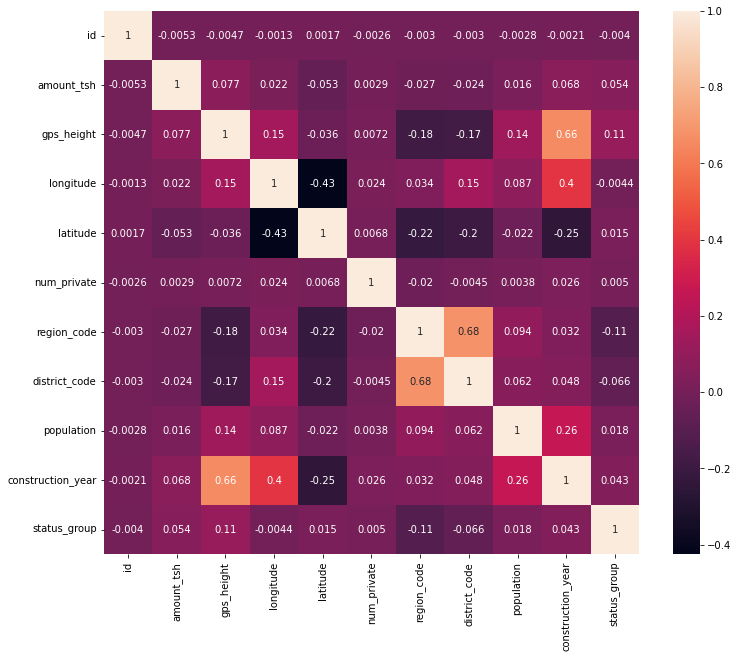

In [4]:
train_1 = train.copy()
train_1['status_group'] = train['status_group'].map({'non functional':0,'functional needs repair':1,'functional':2})
plt.figure(figsize=(12,10))
sns.heatmap(train_1.corr(),annot=True)

In [5]:
def train_val_test_split(df,seed,train_rate,val_rate):
    mixed_indices = df.sample(frac=1,random_state = seed).index
    num_indices = len(mixed_indices)
    train_indices = mixed_indices[:int(num_indices*train_rate)]
    val_indices = mixed_indices[int(num_indices*train_rate): int(num_indices*val_rate)]
    test_indices = mixed_indices[int(num_indices*val_rate):]
    return train_indices,val_indices,test_indices


In [6]:
DROP_COLUMNS = ['num_private'
                ,'amount_tsh'
                ,'subvillage'
                ,'wpt_name'
                ,'installer'
                ,'funder'
                ,'ward'
                ,'recorded_by'
                ,'id'
                ,'scheme_name'
                ,'scheme_management'
                ,'payment_type'
                ,'quantity_group'
                ,'waterpoint_type_group'
                ,'extraction_type_class'
                ,'extraction_type'
                ,'water_quality'
                ,'quality_group'
                ,'lga'
                ,'source'
                ,'region_code'
                ,'public_meeting']

In [7]:
def correcting_datatypes(df):
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['permit'] = df['permit'].astype('bool')
    df['district_code'] = df['district_code'].apply(lambda x: str(x))
    return df
def drop_features(df,features = DROP_COLUMNS):
    df = df.drop(columns = DROP_COLUMNS,axis=1)
    return df
def feature_engineering_age(df): 
    df['date_recorded'] = df['date_recorded'].apply(lambda x: (datetime.datetime.now() - x)).dt.days
    return df

def feature_engineering_gpsheight(df): 
    df['gps_height'] = df['gps_height'].replace(0,np.NaN).interpolate('linear')
    return df

def feature_engineering_longitude(df): 
    df['longitude'] = df['longitude'].replace(0,np.NaN).interpolate('linear')
    return df

def feature_engineering_latitude(df): 
    df['latitude'] = df['latitude'].replace(0,np.NaN).interpolate('linear')
    return df

def feature_engineering_population(df,for_test=False):
    if for_test == False:
        df = df.drop(df[df['population']>1500].index, axis=0)
    df['population'] = df['population'].replace(0,np.NaN).interpolate('linear')
    return df

def feature_engineering_constructionyear(df):
    df['construction_year'] = df['construction_year'].replace(0,np.NaN).interpolate('pad')
    df['construction_year'] = df['construction_year'].apply(lambda x: int(datetime.datetime.now().year) - x)
    return df

def feature_engineering_waterpointtype(df):
    df['waterpoint_type'] = df['waterpoint_type'].replace('dam','other')
    df['waterpoint_type'] = df['waterpoint_type'].replace('cattle trough','other')
    return df

def feature_engineering_pipe(df,for_test=False):
    df = correcting_datatypes(df)
    df = feature_engineering_age(df)
    df = feature_engineering_gpsheight(df)
    df = feature_engineering_constructionyear(df)
    df = feature_engineering_waterpointtype(df)
    df = feature_engineering_latitude(df)
    df = feature_engineering_longitude(df)
    df = feature_engineering_population(df,for_test)
    df = drop_features(df)
    df = interpolate(df)
    df = onehot(df)
    return df

def scaling(train, test=None,val=None):
    stdscaler = StandardScaler()
    stdscaler.fit(train)
    train = stdscaler.transform(train)
    if(np.all(test,None)==False):
        test = stdscaler.transform(test)
    if (np.all(val,None)==False):
        val = stdscaler.transform(val)
    return train,test,val

def pipeline(xtrain_set, predict_set):
    xtrain_set = feature_engineering_pipe(xtrain_set)
    predict_set = feature_engineering_pipe(predict_set,for_test=True)
    xtrain_set,predict_set,_ = scaling(xtrain_set,predict_set,None)
    return xtrain_set,predict_set

# def building_model():



def onehot(df,cols=None):
    if cols == None:
        cols = df.select_dtypes('object').columns
    onehot_df = pd.get_dummies(df,columns=cols,dummy_na=False)
    return onehot_df

def interpolate(train):
    return train.interpolate(method='pad')

def pipeline_y(df,split=True):
    df = feature_engineering_population(df)
    y = df['status_group']
    y = y.map({'functional':0,'non functional':1,'functional needs repair':2})
    if split == True:
        train_indices,val_indices,test_indices = train_val_test_split(y,32,0.7,0.9)
        return y[train_indices],y[val_indices],y[test_indices]
    else:
        return y


# Water quality, Quality group is now also tested.

In [8]:
def build_model(train_processed, y_train, val_processed, y_val):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(307)),
        tf.keras.layers.Dense(16,use_bias=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32,use_bias=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64,use_bias=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(3,use_bias=True),
    ])

    model.compile(
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )

    model.summary()

    model.fit(
        train_processed,
        y_train,
        batch_size=int(train.shape[0]/20),
        epochs=100,
        validation_data = (val_processed,y_val),
    )
    return model

In [9]:
ada_classifier = AdaBoostClassifier(
    base_estimator= None,
    n_estimators=50,
    learning_rate= 0.1,
    random_state=42
)

extratrees_classifier = ExtraTreesClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
)

randomforest_classifier = RandomForestClassifier()
gradientboosting_classifier = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()
svc_classifier = SVC()
decisiontree_classifier = DecisionTreeClassifier()
xgbrf = XGBRFClassifier()
xgbrc = XGBClassifier()

In [10]:
def fitting_models(model_name,train_X,train_y,val_X,val_y):
    model_name.fit(train_X,train_y)
    prediction = model_name.predict(train_X)
    acc1 = accuracy_score(train_y,prediction)
    prediction2 = model_name.predict(val_X)
    acc2 = accuracy_score(val_y,prediction2) 
    print(train_X.shape)
    return model_name,acc1,acc2

In [11]:
# train2 = train.copy()
# train2 = correcting_datatypes(train2)
# train2 = drop_features(train2)

# s = 0
# for i in train2.select_dtypes('object').columns.drop('status_group'):
#     print(f'The number of unique values in column {i} is {train[i].nunique()}')
#     s+= train[i].nunique()
# print(s)

# print(train2.select_dtypes(exclude='object').columns)

In [12]:
# train2 = pd.read_csv('Test_values.csv')
# train2 = correcting_datatypes(train2)
# train2 = drop_features(train2)

# s = 0
# for i in train2.select_dtypes('object').columns:
#     print(f'The number of unique values in column {i} is {train[i].nunique()}')
#     s+= train[i].nunique()
# print(s)

# print(train2.select_dtypes(exclude='object').columns)

In [13]:
cv = KFold(
    n_splits=2,
    shuffle=True,
    random_state=42
)

param_grid={
    'n_estimators':np.arange(50,250,50),
    'criterion':['log_loss','gini'],
    'min_samples_split':np.arange(7,12),
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=None,
    cv= cv,
    verbose=3,
    return_train_score=True)

train_set, prediction_set = pipeline(train.drop(['status_group'],axis=1),pd.read_csv('Test_values.csv'))
train_y = pipeline_y(train,split=False)

grid_search.fit(train_set,train_y)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2] END criterion=log_loss, min_samples_split=7, n_estimators=50;, score=(train=0.931, test=0.798) total time=   2.2s
[CV 2/2] END criterion=log_loss, min_samples_split=7, n_estimators=50;, score=(train=0.927, test=0.795) total time=   2.2s
[CV 1/2] END criterion=log_loss, min_samples_split=7, n_estimators=100;, score=(train=0.933, test=0.799) total time=   4.4s
[CV 2/2] END criterion=log_loss, min_samples_split=7, n_estimators=100;, score=(train=0.930, test=0.796) total time=   4.5s
[CV 1/2] END criterion=log_loss, min_samples_split=7, n_estimators=150;, score=(train=0.932, test=0.798) total time=   6.6s
[CV 2/2] END criterion=log_loss, min_samples_split=7, n_estimators=150;, score=(train=0.931, test=0.797) total time=   6.6s
[CV 1/2] END criterion=log_loss, min_samples_split=7, n_estimators=200;, score=(train=0.933, test=0.800) total time=   8.8s
[CV 2/2] END criterion=log_loss, min_samples_split=7, n_estimators=200;, 

GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss', 'gini'],
                         'min_samples_split': array([ 7,  8,  9, 10, 11]),
                         'n_estimators': array([ 50, 100, 150, 200])},
             return_train_score=True, scoring='accuracy', verbose=3)

In [16]:
x = grid_search.best_estimator_.fit(train_set,train_y)
submit = x.predict(prediction_set)

submit_form = pd.read_csv('Test_values.csv')
submit_form = pd.concat([submit_form['id'].astype('object'),pd.Series(submit).astype('int')],axis=1)
submit_form.columns = ['id','status_group']
submit_form['status_group'] = submit_form['status_group'].map({0:'functional',1:'non functional',2:'functional needs repair'})

submit_form.to_csv('submit.csv',index=False)

In [15]:
grid_search.best_params_

{'criterion': 'log_loss', 'min_samples_split': 7, 'n_estimators': 200}